In [81]:
import pandas as pd
import numpy as np
import datetime 
import os

# Scikit-learn imports
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.utils import estimator_checks
from sklearn.utils.estimator_checks import check_estimator


# Machine learning libraries
import xgboost as xgb
import lightgbm as lgb


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Optuna for hyperparameter tuning
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Saving and loading models
import joblib


# Warning settings
pd.set_option('future.no_silent_downcasting', True)


In [2]:
tf.__version__

'2.19.0'

In [3]:
from scikeras.wrappers import KerasClassifier
print(type(KerasClassifier)) 

<class 'type'>


In [4]:
data = pd.read_csv('../data/Telco-Customer-Churn_cleaned.csv')
df = data.copy()

In [5]:
df.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
# Inspecting columns and unique values
def unique_value_report(df):
    rows = []
    for col in df.columns:
        value_counts = df[col].value_counts(dropna=False)
        formatted = ', '.join([f"{val} ({count})" for val, count in value_counts.items()])
        rows.append({'variable': col, 'values': formatted})
    return pd.DataFrame(rows)

unique_value_report(df)


,variable,values
0,Gender,"male (3555), female (3488)"
1,SeniorCitizen,"no (5901), yes (1142)"
2,Partner,"no (3641), yes (3402)"
3,Dependents,"no (4933), yes (2110)"
4,Tenure,"1 (613), 72 (362), 2 (238), 3 (200), 4 (176), ..."
5,PhoneService,"yes (6361), no (682)"
6,MultipleLines,"no (3390), yes (2971), no phone service (682)"
7,InternetService,"fiber optic (3096), dsl (2421), no (1526)"
8,OnlineSecurity,"no (3498), yes (2019), no internet service (1526)"
9,OnlineBackup,"no (3088), yes (2429), no internet service (1526)"


In [7]:
# 1. Identyfying columns for preprocessing

# Columns categorization
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

## Identify binary columns with only 'yes' and 'no' values
binary_yn_cols = [col for col in df.select_dtypes(include=['object']).columns if set(df[col].unique()) == {'yes', 'no'} and col not in ['Churn']]

## Identify ordinal columns
ordinal_cols = ['Contract']
ordinal_categories = [['month-to-month', 'one year', 'two year']]  # Ordre logique des contrats

## Nominal columns: object columns with more than 2 unique values, excluding ordinal and binary columns
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in ordinal_cols and df[col].nunique() > 2]


In [8]:
target_col = 'Churn'  # Target variable

# Split train / val / test
X_train, X_temp, y_train, y_temp = train_test_split(
    df.drop(columns=[target_col]), df[target_col], test_size=0.3, random_state=42, stratify=df[target_col])

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [9]:
X_train.shape, X_test.shape, X_val.shape, X_test.shape, y_val.shape, y_test.shape

((4930, 19), (1057, 19), (1056, 19), (1057, 19), (1056,), (1057,))

In [10]:
# 2. Normalisation sur les numériques
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

X_train_num.shape, X_val_num.shape, X_test_num.shape

((4930, 3), (1056, 3), (1057, 3))

In [11]:
# 3. Encodage sur les catégorielles
# Encodage des colonnes binaires yes/no en 0/1
map = {'yes': 1, 'no': 0}
X_train[binary_yn_cols] = X_train[binary_yn_cols].replace(map)
X_val[binary_yn_cols] = X_val[binary_yn_cols].replace(map)
X_test[binary_yn_cols] = X_test[binary_yn_cols].replace(map)

# One-hot encoding for nominal categorical columns and 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_val_cat = encoder.transform(X_val[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Ordinal encoding for ordinal columns
ordinal = OrdinalEncoder(categories=ordinal_categories)
X_train_ordinal = ordinal.fit_transform(X_train[ordinal_cols])
X_val_ordinal = ordinal.transform(X_val[ordinal_cols])
X_test_ordinal = ordinal.transform(X_test[ordinal_cols])

In [12]:
X_train_num = np.array(X_train_num)
X_train_cat = np.array(X_train_cat)
X_train_ordinal = np.array(X_train_ordinal)

# 4. Concatenation des numériques et catégorielles
X_train_final = np.hstack([X_train_num, X_train_cat, X_train_ordinal])
X_val_final = np.hstack([X_val_num, X_val_cat, X_val_ordinal])
X_test_final = np.hstack([X_test_num, X_test_cat, X_test_ordinal])

X_train_final.shape, X_val_final.shape, X_test_final.shape

((4930, 32), (1056, 32), (1057, 32))

In [13]:
# 5. Target variable encoding
map_target = {'yes': 1, 'no': 0}
y_train_end = y_train.replace(map_target)
y_val_end = y_val.replace(map_target)
y_test_end = y_test.replace(map_target)

## Final conversion to numpy arrays
y_train_final = y_train_end.to_numpy()
y_val_final = y_val_end.to_numpy()
y_test_final = y_test_end.to_numpy()

y_train_final = y_train_final.astype(np.float32)
y_val_final = y_val_final.astype(np.float32)
y_test_final = y_test_final.astype(np.float32)

y_train_final.shape, y_val_final.shape, y_test_final.shape

((4930,), (1056,), (1057,))

In [14]:
# 6. Class weights for imbalanced classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.680563224737714, 1: 1.8845565749235473}


In [15]:
input_dim = X_train_final.shape[1]

def build_model(input_dim, learning_rate=0.001, num_units=64, dropout_rate=0.3, l2_reg=0.001):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(num_units, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(num_units, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')  # Pour classification binaire
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [16]:
model = build_model(input_dim)
model.summary()

E0000 00:00:1748379403.902863  430482 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748379403.906906  430482 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,337 (24.75 KB)

 Trainable params: 6,337 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    # mode='max',
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = "data/churn_best.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

tensorboard_cb = callbacks.TensorBoard(log_dir='./logs')

In [18]:
# Entraînement
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)


Epoch 1/100
134/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6779 - auc: 0.7070 - loss: 0.7131 - precision: 0.4051 - recall: 0.5275
Epoch 1: val_accuracy improved from -inf to 0.72917, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6834 - auc: 0.7179 - loss: 0.7043 - precision: 0.4152 - recall: 0.5501 - val_accuracy: 0.7292 - val_auc: 0.8370 - val_loss: 0.5881 - val_precision: 0.4934 - val_recall: 0.8000
Epoch 2/100
133/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7472 - auc: 0.8318 - loss: 0.5824 - precision: 0.5188 - recall: 0.7839
Epoch 2: val_accuracy improved from 0.72917 to 0.73390, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7460 - auc: 0.8307 - loss: 0.5830 - precision: 0.5170 - recall: 0.7843 - val_accuracy: 0.7339 - val_auc: 0.8415 - val_loss: 0.5861 - val_precision: 0.4989 - val_recall: 0.8321
Epoch 3/100
137/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7380 - auc: 0.8300 - loss: 0.5790 - precision: 0.5176 - recall: 0.7697
Epoch 3: val_accuracy improved from 0.73390 to 0.73485, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7381 - auc: 0.8301 - loss: 0.5776 - precision: 0.5160 - recall: 0.7697 - val_accuracy: 0.7348 - val_auc: 0.8419 - val_loss: 0.5813 - val_precision: 0.5000 - val_recall: 0.8250
Epoch 4/100
144/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7580 - auc: 0.8467 - loss: 0.5432 - precision: 0.5283 - recall: 0.8031
Epoch 4: val_accuracy improved from 0.73485 to 0.74432, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7571 - auc: 0.8457 - loss: 0.5444 - precision: 0.5271 - recall: 0.8023 - val_accuracy: 0.7443 - val_auc: 0.8432 - val_loss: 0.5526 - val_precision: 0.5112 - val_recall: 0.8143
Epoch 5/100
146/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7499 - auc: 0.8465 - loss: 0.5358 - precision: 0.5197 - recall: 0.7938
Epoch 5: val_accuracy did not improve from 0.74432
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7497 - auc: 0.8460 - loss: 0.5363 - precision: 0.5194 - recall: 0.7940 - val_accuracy: 0.7358 - val_auc: 0.8461 - val_loss: 0.5548 - val_precision: 0.5011 - val_recall: 0.8321
Epoch 6/100
154/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7441 - auc: 0.8436 - loss: 0.5370 - precision: 0.5177 - recall: 0.7982
Epoch 6: val_accuracy did not improve from 0.74432
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7441 - auc: 0.8435 - loss: 0.5370 - precision: 0.5176 - recall: 0.7982 - val_accuracy: 0.7320 - val_auc: 

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7408 - auc: 0.8461 - loss: 0.5190 - precision: 0.5171 - recall: 0.8110 - val_accuracy: 0.7472 - val_auc: 0.8460 - val_loss: 0.5220 - val_precision: 0.5149 - val_recall: 0.8036
Epoch 12/100
138/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7643 - auc: 0.8452 - loss: 0.5141 - precision: 0.5366 - recall: 0.7859
Epoch 12: val_accuracy did not improve from 0.74716
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7636 - auc: 0.8450 - loss: 0.5141 - precision: 0.5357 - recall: 0.7870 - val_accuracy: 0.7320 - val_auc: 0.8479 - val_loss: 0.5350 - val_precision: 0.4967 - val_recall: 0.8179
Epoch 13/100
141/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7340 - auc: 0.8295 - loss: 0.5353 - precision: 0.5064 - recall: 0.7727
Epoch 13: val_accuracy did not improve from 0.74716
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - auc: 0.8308 - loss: 0.5333 - precision: 0.5073 - recall: 0.7745 - val_accuracy: 0.7339 - val_a

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7654 - auc: 0.8460 - loss: 0.5136 - precision: 0.5466 - recall: 0.8100 - val_accuracy: 0.7670 - val_auc: 0.8488 - val_loss: 0.4943 - val_precision: 0.5423 - val_recall: 0.7786
Epoch 19/100
Epoch 19/100
139/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7659 - auc: 0.8465 - loss: 0.5026 - precision: 0.5415 - recall: 0.7727
Epoch 19: val_accuracy did not improve from 0.76705
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7656 - auc: 0.8466 - loss: 0.5027 - precision: 0.5408 - recall: 0.7743 - val_accuracy: 0.7121 - val_auc: 0.8475 - val_loss: 0.5661 - val_precision: 0.4765 - val_recall: 0.8679
Epoch 20/100
142/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7494 - auc: 0.8520 - loss: 0.4967 - precision: 0.5263 - recall: 0.8160
Epoch 20: val_accuracy did not improve from 0.76705
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7501 - auc: 0.8518 - loss: 0.4967 - precision: 0.5263 - recall: 0.8140 - val_accuracy: 0

In [19]:
accuracy, auc, loss, precision, recall = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

Test Accuracy: 0.4801
Test AUC: 0.7767
Test Precision: 0.5620
Test Recall: 0.7260


In [20]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.89      0.80      0.84       776
       Churn       0.56      0.73      0.63       281

    accuracy                           0.78      1057
   macro avg       0.73      0.76      0.74      1057
weighted avg       0.80      0.78      0.78      1057



- Precision (précision) : parmi les exemples prédits positifs, combien sont réellement positifs.
- Recall (rappel) : parmi les exemples réellement positifs, combien ont été détectés (sensibilité).
- F1-score : moyenne harmonique entre précision et rappel, équilibre les deux métriques.
- Support : nombre d'exemples réels dans chaque classe.


### **Analyse des résultats**
**Classe No Churn (non-départ)**
* Précision élevée (0.90) : Quand le modèle prédit "No Churn", il a raison 90 % du temps.
* Rappel plus faible (0.74) : Le modèle détecte 74 % des vrais "No Churn", il manque donc 26 % de ces cas (faux négatifs).
* F1-score solide (0.81), ce qui indique un bon compromis.

**Classe Churn (départ)**
* Précision faible (0.52) : Parmi les prédictions "Churn", seul 52 % sont correctes. Beaucoup de faux positifs.
* Rappel plus élevé (0.78) : Le modèle détecte 78 % des vrais départs, il manque 22 % (faux négatifs).
* F1-score moyen (0.62), indiquant une performance moins satisfaisante pour cette classe.

**Performance globale**
* Accuracy de 0.75 : 75 % des prédictions globales sont correctes, mais ce chiffre est à nuancer car les classes sont déséquilibrées (plus de No Churn).
* La moyenne macro (qui donne un poids égal aux classes) est plus basse (F1-score 0.72), ce qui montre que la performance sur la classe minoritaire (Churn) tire vers le bas la moyenne.

### **Interprétation business & recommandations**
- ***Déséquilibre de classes*** : Le nombre de "No Churn" est presque 3 fois celui des "Churn". L’accuracy seule peut être trompeuse dans ce cas.
- ***Précision faible sur Churn*** : Le modèle génère beaucoup de faux positifs — en pratique, cela signifie que beaucoup de clients sont faussement identifiés comme partants.
- ***Rappel élevé sur Churn*** : Le modèle détecte une majorité des vrais clients partants, ce qui est important si l’objectif est de réduire le churn en intervenant tôt.

In [21]:
print("Matrice de Confusion :")
cm = confusion_matrix(y_test_final, y_pred)
print(cm)

Matrice de Confusion :
[[617 159]
 [ 77 204]]


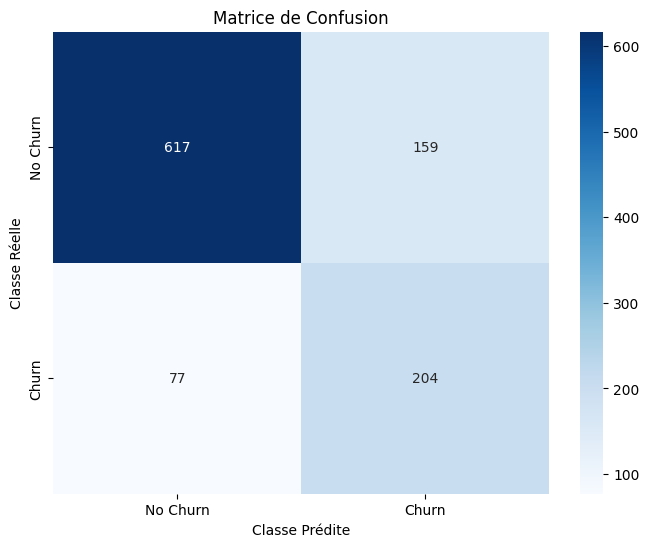

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Matrice de Confusion")
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.show()

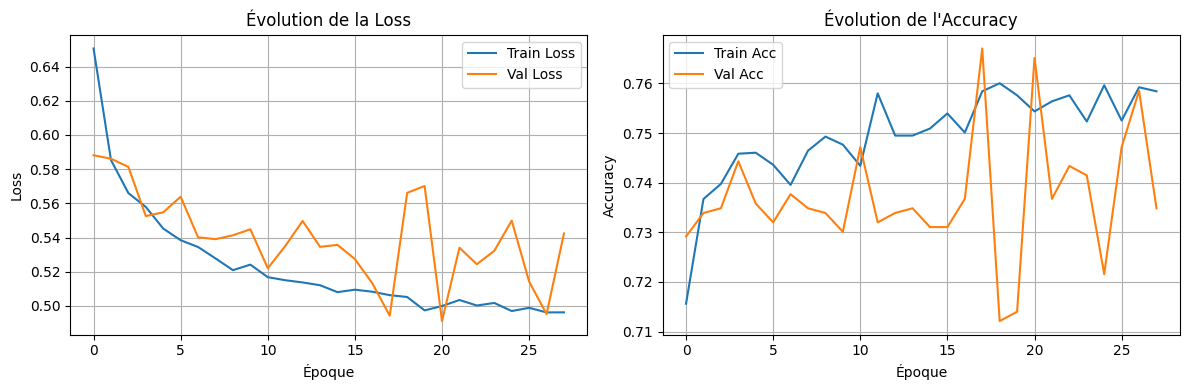

In [23]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history)

### 3. TensorBoard

TensorBoard est un outil de visualisation et de suivi des métriques d'entraînement des modèles de Deep Learning. Il permet d'explorer les performances du modèle, de diagnostiquer les problèmes et d'optimiser les hyperparamètres. Grâce à ses fonctionnalités interactives, TensorBoard offre une vue d'ensemble des courbes de perte et d'accuracy, des distributions des poids, des gradients, et bien plus encore.

Voici quelques-unes des fonctionnalités principales de TensorBoard :
- **Suivi des métriques** : Visualisation des courbes de perte, d'accuracy, etc.
- **Exploration des distributions** : Histogrammes des poids et des gradients.
- **Visualisation du graphe du modèle** : Compréhension de la structure du réseau.
- **Analyse des hyperparamètres** : Comparaison des performances pour différents réglages.

TensorBoard est un outil essentiel pour tout projet de Deep Learning, facilitant l'interprétation des résultats et l'amélioration des modèles.

* **`log_dir`** : dossier où seront écrits les logs (scalars, histogrammes, graph, images).

* **`histogram_freq=1`** : enregistre chaque époque les distributions de poids et de gradients.

* **`write_graph=True`** : sauvegarde la définition du modèle pour visualiser le graph.

In [24]:
%load_ext tensorboard

In [25]:
log_dir = os.path.join(
    "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,       # enregistre les histogrammes de poids chaque époque
    write_graph=True,       # sauvegarde le graph du modèle
    write_images=True
)

In [26]:
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)


Epoch 1/100
142/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7651 - auc: 0.8538 - loss: 0.4900 - precision: 0.5317 - recall: 0.7886
Epoch 1: val_accuracy did not improve from 0.76705
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7641 - auc: 0.8531 - loss: 0.4912 - precision: 0.5309 - recall: 0.7888 - val_accuracy: 0.7595 - val_auc: 0.8461 - val_loss: 0.5005 - val_precision: 0.5312 - val_recall: 0.7893
Epoch 2/100
145/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7699 - auc: 0.8450 - loss: 0.5034 - precision: 0.5337 - recall: 0.7772
Epoch 2: val_accuracy did not improve from 0.76705
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7692 - auc: 0.8450 - loss: 0.5034 - precision: 0.5336 - recall: 0.7777 - val_accuracy: 0.7121 - val_auc: 0.8464 - val_loss: 0.5446 - val_precision: 0.4761 - val_recall: 0.8536
Epoch 3/100
148/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7423 - auc: 0.8371 - loss: 0.5210 - precision: 0.5140 - recall: 0.8128
Epoch 3: val_accuracy 

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7632 - auc: 0.8478 - loss: 0.4984 - precision: 0.5339 - recall: 0.8021 - val_accuracy: 0.7699 - val_auc: 0.8453 - val_loss: 0.4800 - val_precision: 0.5468 - val_recall: 0.7714
Epoch 7/100
Epoch 7/100
150/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7569 - auc: 0.8438 - loss: 0.5070 - precision: 0.5312 - recall: 0.7821
Epoch 7: val_accuracy did not improve from 0.76989
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7569 - auc: 0.8440 - loss: 0.5067 - precision: 0.5312 - recall: 0.7824 - val_accuracy: 0.7547 - val_auc: 0.8473 - val_loss: 0.5107 - val_precision: 0.5248 - val_recall: 0.7929
Epoch 8/100
154/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7712 - auc: 0.8555 - loss: 0.4777 - precision: 0.5305 - recall: 0.8005
Epoch 8: val_accuracy did not improve from 0.76989
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7711 - auc: 0.8554 - loss: 0.4779 - precision: 0.5305 - recall: 0.8005 - val_accuracy: 0.7273

In [27]:
test_acc, test_auc, test_loss, test_precesion, test_recall  = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precesion:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.4675
Test AUC: 0.7729
Test Precision: 0.5565
Test Recall: 0.7189


In [28]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.89      0.79      0.84       776
       Churn       0.56      0.72      0.63       281

    accuracy                           0.77      1057
   macro avg       0.72      0.76      0.73      1057
weighted avg       0.80      0.77      0.78      1057



In [29]:
%tensorboard --logdir logs/fit

In [30]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_final, y_train_final)

In [31]:
# Entraînement
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)

Epoch 1/100
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7755 - auc: 0.8559 - loss: 0.4860 - precision: 0.7584 - recall: 0.7975
Epoch 1: val_accuracy did not improve from 0.76989
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7756 - auc: 0.8560 - loss: 0.4858 - precision: 0.7590 - recall: 0.7976 - val_accuracy: 0.7509 - val_auc: 0.8466 - val_loss: 0.5111 - val_precision: 0.5201 - val_recall: 0.7857
Epoch 2/100
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - auc: 0.8575 - loss: 0.4828 - precision: 0.7685 - recall: 0.8082
Epoch 2: val_accuracy did not improve from 0.76989
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7821 - auc: 0.8574 - loss: 0.4828 - precision: 0.7683 - recall: 0.8076 - val_accuracy: 0.7566 - val_auc: 0.8461 - val_loss: 0.5000 - val_precision: 0.5274 - val_recall: 0.7893
Epoch 3/100
212/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - auc: 0.8689 - loss: 0.4687 - precision: 0.7835 - recall: 0.8086
Epoch 3: val_accuracy 

In [32]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.88      0.81      0.84       776
       Churn       0.57      0.71      0.63       281

    accuracy                           0.78      1057
   macro avg       0.73      0.76      0.74      1057
weighted avg       0.80      0.78      0.79      1057



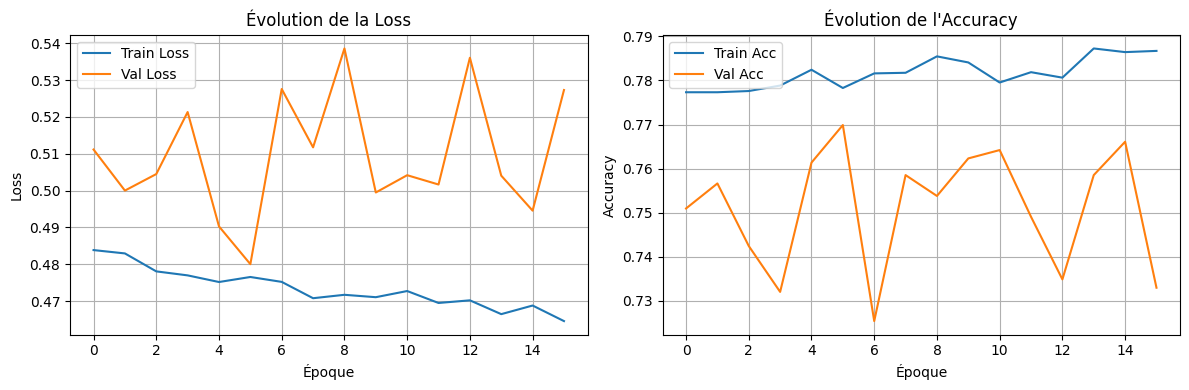

In [33]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history)

In [34]:
def build_model_advanced(
    input_dim, 
    num_units=64, 
    dropout_rate=0.3,
    learning_rate=0.001,
    l2_reg=0.001,
    use_batchnorm=True
):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # Premier bloc dense
    model.add(layers.Dense(num_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Deuxième bloc dense
    model.add(layers.Dense(num_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))

    # Batch Normalization et Dropout
    ## Sert à stabiliser l'entraînement et à réduire le sur-apprentissage
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Couche de sortie
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [35]:
# Optimisation des hyperparamètres avec RandomizedSearchCV

model = KerasClassifier(
    model=build_model_advanced,
    model__input_dim=input_dim,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=0,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    random_state=42
)

In [36]:
# Define the hyperparameter grid
param_grid = {
    'model__num_units': [32, 64, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__learning_rate': [0.001, 0.01],
    'model__l2_reg': [0.0001, 0.001],
    'model__use_batchnorm': [True, False],
    'batch_size': [32, 64]
}


# Create the GridSearch object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # métrique adaptée au déséquilibre
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [ ]:
# Fit the model
grid_search.fit(X_train_final, y_train_final, validation_data=(X_val_final, y_val_final))

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

In [40]:
def objective(trial):
    # Suggest hyperparams
    num_units = trial.suggest_categorical("num_units", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    model = build_model_advanced(
        input_dim=input_dim,
        num_units=num_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        l2_reg=l2_reg,
        use_batchnorm=use_batchnorm
    )

    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val_final, y_val_final),
        batch_size=batch_size,
        epochs=50,
        verbose=0,
        class_weight=class_weight_dict,
        callbacks=[
            callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            TFKerasPruningCallback(trial, "val_auc")
        ]
    )

    val_auc = max(history.history["val_auc"])
    return val_auc

# Étude Optuna
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

# Résultats
print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-27 23:01:36,101] A new study created in memory with name: no-name-cbcb8473-d027-42ed-a86a-966f14f15686
/tmp/ipykernel_430482/2681377620.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/tmp/ipykernel_430482/2681377620.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)
[I 2025-05-27 23:01:46,259] Trial 0 finished with value: 0.8501173257827759 and parameters: {'num_units': 128, 'dropout_rate': 0.35817741092778305, 'learning_rate': 0.0006136992426248312, 'l2_reg': 0.003245028835124844, 'use_batchnorm': False, 'batch_size': 32}. Best 

Best AUC: 0.8501979112625122
Best params: {'num_units': 128, 'dropout_rate': 0.2489625491739106, 'learning_rate': 0.0004374735224483399, 'l2_reg': 0.001483602872886869, 'use_batchnorm': False, 'batch_size': 32}


In [44]:
def objective(trial):
    # Suggère les hyperparamètres
    num_units = trial.suggest_categorical("num_units", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    model = build_model_advanced(
        input_dim=input_dim,
        num_units=num_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        l2_reg=l2_reg,
        use_batchnorm=use_batchnorm
    )

    # Entraînement
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val_final, y_val_final),
        batch_size=batch_size,
        epochs=50,
        verbose=0,
        class_weight=class_weight_dict,
        callbacks=[
            callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            TFKerasPruningCallback(trial, "val_auc")
        ]
    )

    val_auc = max(history.history["val_auc"])

    # Sauvegarde du meilleur modèle
    trial.set_user_attr("best_epoch", int(np.argmax(history.history["val_auc"])))
    return val_auc

In [45]:
study_name = "auc_tuning_study"
storage_path = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_path,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50, timeout=None)

# Résumé
print("Best trial:")
print(f"  Value: {study.best_value}")
print(f"  Params: {study.best_params}")


[I 2025-05-27 23:06:24,478] Using an existing study with name 'auc_tuning_study' instead of creating a new one.
[I 2025-05-27 23:06:26,265] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-05-27 23:06:28,139] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-05-27 23:06:31,122] Trial 9 pruned. Trial was pruned at epoch 3.
[I 2025-05-27 23:06:34,279] Trial 10 pruned. Trial was pruned at epoch 2.
[I 2025-05-27 23:06:36,080] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-05-27 23:06:38,360] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-05-27 23:06:45,483] Trial 13 finished with value: 0.8480371236801147 and parameters: {'num_units': 128, 'dropout_rate': 0.41358392611635697, 'learning_rate': 0.0009447722590589325, 'l2_reg': 0.009352260959896119, 'use_batchnorm': False, 'batch_size': 32}. Best is trial 2 with value: 0.8501196503639221.
[I 2025-05-27 23:06:47,368] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-05-27 23:06:50,246] Trial 15 pruned. Trial was pruned

Best trial:
  Value: 0.8503060340881348
  Params: {'num_units': 64, 'dropout_rate': 0.3484336557568852, 'learning_rate': 0.0013167830663626259, 'l2_reg': 0.0032351901786996486, 'use_batchnorm': False, 'batch_size': 64}


In [51]:
# Reconstruction du meilleur modèle
best_params = study.best_params
best_model = build_model_advanced(
    input_dim=input_dim,
    num_units=best_params["num_units"],
    dropout_rate=best_params["dropout_rate"],
    learning_rate=best_params["learning_rate"],
    l2_reg=best_params["l2_reg"],
    use_batchnorm=best_params["use_batchnorm"]
)

# Réentraînement complet sur tout le jeu d'entraînement
best_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    # Utilisation des meilleurs hyperparamètres
    validation_split=0.2,
    epochs=50,
    batch_size=int(best_params["batch_size"]),
    verbose=0,
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Sauvegarde
best_model.save("best_model.h5")
joblib.dump(study, "optuna_study.pkl")


['optuna_study.pkl']

In [52]:
print("Best trial:")
print(f"  Value: {study.best_value}")
print(f"  Params: {study.best_params}")


Best trial:
  Value: 0.8503060340881348
  Params: {'num_units': 64, 'dropout_rate': 0.3484336557568852, 'learning_rate': 0.0013167830663626259, 'l2_reg': 0.0032351901786996486, 'use_batchnorm': False, 'batch_size': 64}


In [ ]:
check_estimator(model)

In [58]:
best_params = study.best_trial.params
best_threshold = study.best_trial.user_attrs.get("best_threshold", 0.5)  # fallback 0.5

In [59]:
# Prédictions de probabilités
y_pred_proba = best_model.predict(X_test_final).flatten()

# Application du seuil optimal
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Rapport de classification
print(classification_report(y_test_final, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83       776
         1.0       0.54      0.75      0.63       281

    accuracy                           0.77      1057
   macro avg       0.72      0.76      0.73      1057
weighted avg       0.80      0.77      0.78      1057



In [60]:
print("Matrice de Confusion :")
cm = confusion_matrix(y_test_final, y_pred)
print(cm)

Matrice de Confusion :
[[598 178]
 [ 70 211]]


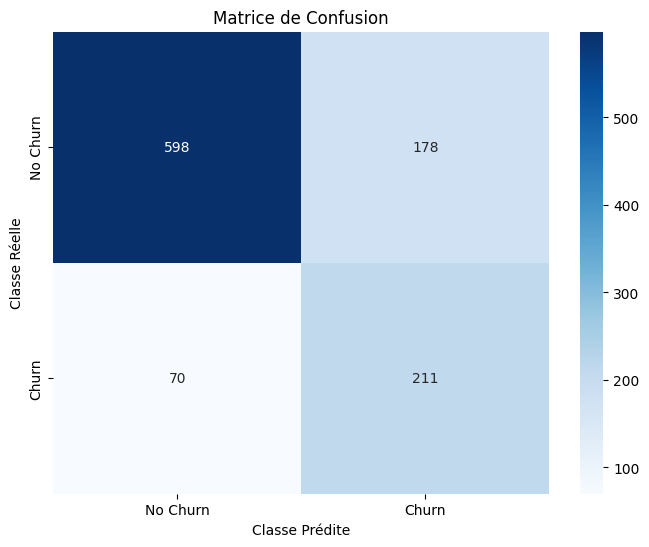

In [61]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Matrice de Confusion")
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.show()

In [ ]:
# Best parameters and score
print("Test AUC:", roc_auc_score(y_test_final, y_pred_proba))
print("Best parameters found:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)

In [ ]:
# Best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test_final, y_test_final)
print("Test Score:", test_score)

In [ ]:
# Save the best model
best_model.model.save('best_churn_model.h5')

In [ ]:
# Visualisation des performances du modèle
def plot_performance(y_true, y_pred_probs):
    """
    Trace les performances du modèle avec une courbe ROC et une matrice de confusion.
    """
    # Courbe ROC
    fpr, tpr, thresholds = tf.keras.metrics.roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC')
    plt.legend()
    plt.grid()
    plt.show()

    # Matrice de confusion
    cm = confusion_matrix(y_true, (y_pred_probs > 0.5).astype(int))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title("Matrice de Confusion")
    plt.xlabel("Classe Prédite")
    plt.ylabel("Classe Réelle")
    plt.show()
# Appel de la fonction pour visualiser les performances
plot_performance(y_test_final, y_pred_probs)

In [ ]:
print("TensorFlow version:", tf.__version__)

In [64]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_final, y_train_final)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_final)[:, 1]
print("Baseline XGBoost ROC-AUC:", roc_auc_score(y_test_final, y_pred_proba_xgb))


Baseline XGBoost ROC-AUC: 0.8107252265473088


In [ ]:
from sklearn.metrics import f1_score

def objective(trial):
    num_units = trial.suggest_int("num_units", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])
    
    model = build_model_advanced(
        input_dim=input_dim,
        num_units=num_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        l2_reg=l2_reg,
        use_batchnorm=use_batchnorm
    )
    
    model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val_final, y_val_final),
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0,
        class_weight=class_weight_dict,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )
    
    # Prédictions probabilistes sur validation
    y_val_proba = model.predict(X_val_final).ravel()
    
    # Recherche du seuil optimal sur validation
    best_threshold = 0.5
    best_f1 = 0.0
    for threshold in [i * 0.01 for i in range(30, 71)]:  # de 0.3 à 0.7
        y_val_pred = (y_val_proba >= threshold).astype(int)
        f1 = f1_score(y_val_final, y_val_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # On retourne l'inverse de la meilleure F1 (Optuna minimise la fonction)
    trial.set_user_attr("best_threshold", best_threshold)
    return 1 - best_f1


In [79]:
# Suppression ou création d'un nouveau study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


best_params = study.best_params
best_threshold = study.best_trial.user_attrs["best_threshold"]

# Reconstruire le modèle avec les meilleurs hyperparamètres
best_model = build_model_advanced(
    input_dim=input_dim,
    num_units=best_params["num_units"],
    dropout_rate=best_params["dropout_rate"],
    learning_rate=best_params["learning_rate"],
    l2_reg=best_params["l2_reg"],
    use_batchnorm=best_params["use_batchnorm"]
)

best_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

# Prédiction sur test avec seuil optimal
y_test_proba = best_model.predict(X_test_final).ravel()
y_test_pred = (y_test_proba >= best_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test_final, y_test_pred))


[I 2025-05-27 23:26:01,558] A new study created in memory with name: no-name-f32fd106-aa98-4b5b-acfe-c255c050804a
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:26:07,285] Trial 0 finished with value: 0.35048231511254013 and parameters: {'num_units': 86, 'dropout_rate': 0.24478673859855332, 'learning_rate': 0.0005210807603711106, 'l2_reg': 2.477687202500175e-05, 'use_batchnorm': False}. Best is trial 0 with value: 0.35048231511254013.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:26:12,196] Trial 1 finished with value: 0.3751743375174337 and parameters: {'num_units': 44, 'dropout_rate': 0.21311852576939042, 'learning_rate': 0.005937214703103794, 'l2_reg': 0.006194974854445674, 'use_batchnorm': False}. Best is trial 1 with value: 0.3751743375174337.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:26:19,209] Trial 2 finished with value: 0.3579881656804733 and parameters: {'num_units': 76, 'dropout_rate': 0.4011712088738746, 'learning_rate': 0.0039740835821402325, 'l2_reg': 0.004572616248955461, 'use_batchnorm': False}. Best is trial 1 with value: 0.3751743375174337.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:26:28,872] Trial 3 finished with value: 0.359375 and parameters: {'num_units': 62, 'dropout_rate': 0.4495832838581586, 'learning_rate': 0.0003700510386213618, 'l2_reg': 8.981829410189709e-05, 'use_batchnorm': True}. Best is trial 1 with value: 0.3751743375174337.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:26:32,698] Trial 4 finished with value: 0.3633802816901409 and parameters: {'num_units': 54, 'dropout_rate': 0.40242943258429686, 'learning_rate': 0.00734036187123784, 'l2_reg': 0.0009688904628731813, 'use_batchnorm': False}. Best is trial 1 with value: 0.3751743375174337.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


[I 2025-05-27 23:26:38,889] Trial 5 finished with value: 0.357495881383855 and parameters: {'num_units': 55, 'dropout_rate': 0.38773752464845546, 'learning_rate': 0.0005411040036938524, 'l2_reg': 3.2574985305333644e-05, 'use_batchnorm': False}. Best is trial 1 with value: 0.3751743375174337.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:00,625] Trial 6 finished with value: 0.3565768621236133 and parameters: {'num_units': 109, 'dropout_rate': 0.27630271654726657, 'learning_rate': 0.00010025942837043941, 'l2_reg': 0.00434161757761514, 'use_batchnorm': True}. Best is trial 1 with value: 0.3751743375174337.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:05,340] Trial 7 finished with value: 0.3648854961832061 and parameters: {'num_units': 93, 'dropout_rate': 0.4963434531148757, 'learning_rate': 0.00030908265644459944, 'l2_reg': 0.00058234318923564, 'use_batchnorm': True}. Best is trial 1 with value: 0.3751743375174337.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:10,012] Trial 8 finished with value: 0.36 and parameters: {'num_units': 85, 'dropout_rate': 0.28095858308254973, 'learning_rate': 0.0003754775790230586, 'l2_reg': 3.550998261647171e-05, 'use_batchnorm': True}. Best is trial 1 with value: 0.3751743375174337.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:14,829] Trial 9 finished with value: 0.40130718954248357 and parameters: {'num_units': 102, 'dropout_rate': 0.27313040448754344, 'learning_rate': 0.0001056949083971586, 'l2_reg': 0.0002672467707572462, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:19,738] Trial 10 finished with value: 0.37572254335260125 and parameters: {'num_units': 126, 'dropout_rate': 0.32286060789016297, 'learning_rate': 0.00011386172451877412, 'l2_reg': 0.00014792836107316713, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:25,935] Trial 11 finished with value: 0.35854765506807873 and parameters: {'num_units': 128, 'dropout_rate': 0.31686094474437154, 'learning_rate': 0.00010303669188904348, 'l2_reg': 0.00019724735387708544, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:30,568] Trial 12 finished with value: 0.35838150289017334 and parameters: {'num_units': 128, 'dropout_rate': 0.34075608481838104, 'learning_rate': 0.0020066537827751318, 'l2_reg': 0.00016726735866522642, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:35,490] Trial 13 finished with value: 0.3703099510603588 and parameters: {'num_units': 107, 'dropout_rate': 0.2991846349734218, 'learning_rate': 0.00015286520401882527, 'l2_reg': 0.0010617115921343272, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:45,184] Trial 14 finished with value: 0.37235772357723584 and parameters: {'num_units': 110, 'dropout_rate': 0.2021252693444751, 'learning_rate': 0.00020042643467259959, 'l2_reg': 8.154452921645297e-05, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-05-27 23:27:50,624] Trial 15 finished with value: 0.3623188405797101 and parameters: {'num_units': 116, 'dropout_rate': 0.3573449113110839, 'learning_rate': 0.0011716806886322548, 'l2_reg': 1.0131476272847729e-05, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:27:55,590] Trial 16 finished with value: 0.3760262725779967 and parameters: {'num_units': 98, 'dropout_rate': 0.2561982930220177, 'learning_rate': 0.00019838520847036202, 'l2_reg': 0.00047213096938845435, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:28:04,736] Trial 17 finished with value: 0.35331230283911663 and parameters: {'num_units': 97, 'dropout_rate': 0.24026176624821446, 'learning_rate': 0.00021390997031651784, 'l2_reg': 0.0005129379686956648, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:28:21,086] Trial 18 finished with value: 0.3581081081081081 and parameters: {'num_units': 72, 'dropout_rate': 0.25831147244730696, 'learning_rate': 0.0010965467302374748, 'l2_reg': 0.001986647688564853, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:28:26,324] Trial 19 finished with value: 0.35862068965517246 and parameters: {'num_units': 99, 'dropout_rate': 0.23027062709239673, 'learning_rate': 0.0007417252444337602, 'l2_reg': 0.0004011744426965663, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:28:48,244] Trial 20 finished with value: 0.37228714524207007 and parameters: {'num_units': 70, 'dropout_rate': 0.27671626809287986, 'learning_rate': 0.00019653255088153786, 'l2_reg': 0.002111211780157051, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-05-27 23:28:54,042] Trial 21 finished with value: 0.3811533052039381 and parameters: {'num_units': 119, 'dropout_rate': 0.32968474350001586, 'learning_rate': 0.00013390364684865065, 'l2_reg': 0.00021167522154961146, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:28:59,724] Trial 22 finished with value: 0.3749999999999999 and parameters: {'num_units': 115, 'dropout_rate': 0.3017955341122376, 'learning_rate': 0.0001460940954088706, 'l2_reg': 0.0002726198753183683, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:29:12,277] Trial 23 finished with value: 0.35426008968609857 and parameters: {'num_units': 102, 'dropout_rate': 0.37044636011305127, 'learning_rate': 0.00025964972576215657, 'l2_reg': 8.504476882173588e-05, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:29:16,977] Trial 24 finished with value: 0.3752012882447665 and parameters: {'num_units': 118, 'dropout_rate': 0.3271428326313074, 'learning_rate': 0.0001369887915629489, 'l2_reg': 0.0008590880907288921, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:29:25,122] Trial 25 finished with value: 0.365925925925926 and parameters: {'num_units': 91, 'dropout_rate': 0.26224314383394126, 'learning_rate': 0.0016490215460998588, 'l2_reg': 0.00026418658393495, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:29:40,966] Trial 26 finished with value: 0.3675762439807383 and parameters: {'num_units': 33, 'dropout_rate': 0.29743780859119673, 'learning_rate': 0.000173815656647443, 'l2_reg': 0.002093006379243715, 'use_batchnorm': False}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:29:56,178] Trial 27 finished with value: 0.37190082644628086 and parameters: {'num_units': 103, 'dropout_rate': 0.22590350171364687, 'learning_rate': 0.00027797751159683824, 'l2_reg': 5.232673070349172e-05, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:30:00,949] Trial 28 finished with value: 0.3534743202416919 and parameters: {'num_units': 120, 'dropout_rate': 0.43004450997355625, 'learning_rate': 0.0006559665329396695, 'l2_reg': 0.00012802419621416882, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


[I 2025-05-27 23:30:04,715] Trial 29 finished with value: 0.3538461538461538 and parameters: {'num_units': 92, 'dropout_rate': 0.2531870531681949, 'learning_rate': 0.00042434766216252815, 'l2_reg': 1.562358938559927e-05, 'use_batchnorm': False}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:30:19,056] Trial 30 finished with value: 0.3553223388305847 and parameters: {'num_units': 85, 'dropout_rate': 0.35855083640757296, 'learning_rate': 0.00013229626526216654, 'l2_reg': 0.000648956076966871, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:30:24,343] Trial 31 finished with value: 0.36390532544378695 and parameters: {'num_units': 122, 'dropout_rate': 0.32349011945365663, 'learning_rate': 0.00010900456474353646, 'l2_reg': 0.0003232808821422739, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:30:29,255] Trial 32 finished with value: 0.36037441497659917 and parameters: {'num_units': 112, 'dropout_rate': 0.33634500975893056, 'learning_rate': 0.0002387393018204957, 'l2_reg': 0.00016290485807098182, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:30:41,193] Trial 33 finished with value: 0.3545310015898252 and parameters: {'num_units': 123, 'dropout_rate': 0.29993524842300495, 'learning_rate': 0.00012552044343288717, 'l2_reg': 5.3677580531786625e-05, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:30:44,894] Trial 34 finished with value: 0.35451505016722407 and parameters: {'num_units': 103, 'dropout_rate': 0.31535434288977765, 'learning_rate': 0.003938662853130787, 'l2_reg': 0.0001122197038555491, 'use_batchnorm': False}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:30:49,870] Trial 35 finished with value: 0.38088012139605465 and parameters: {'num_units': 78, 'dropout_rate': 0.2817065954661584, 'learning_rate': 0.00017848590691202517, 'l2_reg': 0.00023720148238758185, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:30:59,264] Trial 36 finished with value: 0.3604826546003017 and parameters: {'num_units': 78, 'dropout_rate': 0.21987123202177483, 'learning_rate': 0.0001730704603835344, 'l2_reg': 0.0003860749602927184, 'use_batchnorm': False}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:31:04,314] Trial 37 finished with value: 0.37609329446064144 and parameters: {'num_units': 64, 'dropout_rate': 0.2706237160157585, 'learning_rate': 0.00033039697296543196, 'l2_reg': 0.0012631075075804341, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:31:18,885] Trial 38 finished with value: 0.3510324483775811 and parameters: {'num_units': 65, 'dropout_rate': 0.2851810214748665, 'learning_rate': 0.000487227892384778, 'l2_reg': 0.0013075948975746763, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:31:34,738] Trial 39 finished with value: 0.35522388059701493 and parameters: {'num_units': 58, 'dropout_rate': 0.23910164886509058, 'learning_rate': 0.0003237651724894139, 'l2_reg': 0.003958882967224996, 'use_batchnorm': False}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:31:57,740] Trial 40 finished with value: 0.35126050420168065 and parameters: {'num_units': 45, 'dropout_rate': 0.3793068861488379, 'learning_rate': 0.0003320879197790551, 'l2_reg': 0.0062976822474108225, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:32:08,106] Trial 41 finished with value: 0.3572593800978793 and parameters: {'num_units': 82, 'dropout_rate': 0.266145790426099, 'learning_rate': 0.0001697667401747591, 'l2_reg': 0.000210264005431712, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:32:12,777] Trial 42 finished with value: 0.35618479880774967 and parameters: {'num_units': 71, 'dropout_rate': 0.24864413538743524, 'learning_rate': 0.00023716451984812336, 'l2_reg': 0.0006415083081983325, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:32:27,248] Trial 43 finished with value: 0.362095531587057 and parameters: {'num_units': 89, 'dropout_rate': 0.2881267071543029, 'learning_rate': 0.00010266016331851555, 'l2_reg': 0.0004113044037901378, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:32:48,577] Trial 44 finished with value: 0.36544850498338877 and parameters: {'num_units': 65, 'dropout_rate': 0.26985036445737914, 'learning_rate': 0.0001441601536959551, 'l2_reg': 0.0015177789597692996, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:32:53,323] Trial 45 finished with value: 0.3699515347334411 and parameters: {'num_units': 82, 'dropout_rate': 0.28647449371324896, 'learning_rate': 0.00040149921986508327, 'l2_reg': 0.00021674773211938946, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:33:04,007] Trial 46 finished with value: 0.3616352201257862 and parameters: {'num_units': 95, 'dropout_rate': 0.20472041281727996, 'learning_rate': 0.000197543860475122, 'l2_reg': 0.0008664039055040525, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:33:08,823] Trial 47 finished with value: 0.36378466557911915 and parameters: {'num_units': 74, 'dropout_rate': 0.3094449373245204, 'learning_rate': 0.0002865840598029879, 'l2_reg': 0.0002913081620995731, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:33:18,866] Trial 48 finished with value: 0.3679525222551929 and parameters: {'num_units': 106, 'dropout_rate': 0.23388483366743446, 'learning_rate': 0.0005995225579204293, 'l2_reg': 0.0005519321475859944, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/tmp/ipykernel_430482/978458338.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-2)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-05-27 23:33:24,005] Trial 49 finished with value: 0.3967391304347826 and parameters: {'num_units': 54, 'dropout_rate': 0.4968667671555298, 'learning_rate': 0.00012149846761144067, 'l2_reg': 0.00011286432128526754, 'use_batchnorm': True}. Best is trial 9 with value: 0.40130718954248357.
/home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,auc,loss,precision,recall
  current = self.get_monitor_value(logs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81       776
         1.0       0.51      0.78      0.61       281

    accuracy                           0.74      1057
   macro avg       0.70      0.75      0.71      1057
weighted avg       0.80      0.74      0.75      1057



In [82]:
fig_history = plot_optimization_history(study)
fig_history.show()


In [83]:
fig_importance = plot_param_importances(study)
fig_importance.show()


In [84]:
# 1) Histoire de l'optimisation
plot_optimization_history(study).show()

# 2) Importance des hyperparamètres
plot_param_importances(study).show()

# 3) Coordonnées parallèles (interactions entre paramètres)
plot_parallel_coordinate(study).show()

# 4) Visualisation slice
plot_slice(study).show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


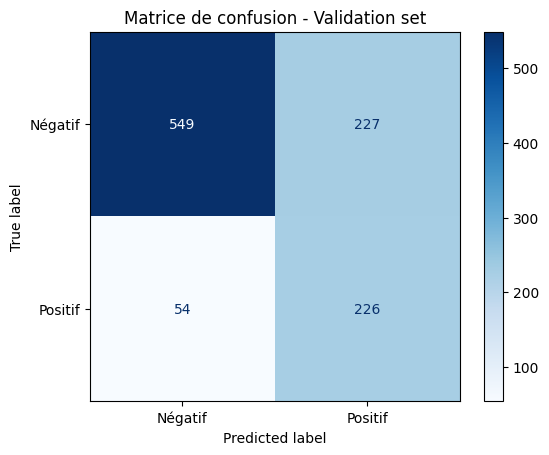

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions probabilistes avec le modèle final sur validation/test
y_val_proba = best_model.predict(X_val_final).ravel()

# Seuillage avec le meilleur threshold (déjà obtenu dans study ou à définir)
best_threshold = 0.5  # Remplacez par votre best_threshold si disponible

# Binarisation
y_val_pred = (y_val_proba > best_threshold).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_val_final, y_val_pred)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Négatif", "Positif"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Validation set")
plt.show()



In [ ]:
def create_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(X_train_final.shape[1],)))
    for i in range(n_layers):
        units = trial.suggest_int(f"units_l{i}", 50, 300)
        model.add(tf.keras.layers.Dense(units, activation="relu",
                                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        if use_batchnorm:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy")
    return model

def objective(trial):
    model = create_model(trial)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val_final, y_val_final),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    y_val_pred = model.predict(X_val_final).ravel()
    auc = roc_auc_score(y_val_final, y_val_pred)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print(f"Best trial:\n  Value: {study.best_trial.value}")
print(f"  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-27 23:43:07,904] A new study created in memory with name: no-name-85039c65-e4cc-4e20-afef-3da9d92d4928


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:43:12,443] Trial 0 finished with value: 0.85098720544919 and parameters: {'n_layers': 1, 'dropout_rate': 0.26064908476703197, 'learning_rate': 0.0008183560009903806, 'l2_reg': 0.0009392439675120517, 'use_batchnorm': True, 'units_l0': 58, 'batch_size': 64}. Best is trial 0 with value: 0.85098720544919.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:43:42,626] Trial 1 finished with value: 0.84983661634757 and parameters: {'n_layers': 3, 'dropout_rate': 0.40373566074666645, 'learning_rate': 8.054427352589324e-05, 'l2_reg': 0.003982399195952104, 'use_batchnorm': False, 'units_l0': 259, 'units_l1': 104, 'units_l2': 148, 'batch_size': 16}. Best is trial 0 with value: 0.85098720544919.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-05-27 23:44:04,280] Trial 2 finished with value: 0.8391361377025037 and parameters: {'n_layers': 3, 'dropout_rate': 0.37867395163077977, 'learning_rate': 3.603760749224578e-05, 'l2_reg': 0.003952958305907019, 'use_batchnorm': True, 'units_l0': 266, 'units_l1': 260, 'units_l2': 248, 'batch_size': 64}. Best is trial 0 with value: 0.85098720544919.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-27 23:44:15,671] Trial 3 finished with value: 0.8431678019145802 and parameters: {'n_layers': 1, 'dropout_rate': 0.486513503203711, 'learning_rate': 0.00010746108605794918, 'l2_reg': 0.002276181875881044, 'use_batchnorm': True, 'units_l0': 287, 'batch_size': 64}. Best is trial 0 with value: 0.85098720544919.
